## Group Name: IntiLP (Intelligent Language Processing)

## Project Name: CancerMine - text-mined knowledgebase

## Group Members: 
* Disha Lamba
* Kiarash Rastegar
* Somasundaram Palaniappan
* Mercy Oyekanmi

## Email: 
* Disha: jb.dishalamba@gmail.com
* Kiarash: krastegar0@gmail.com 
* Somu: plsaran97@gmail.com
* Mercy: creativeart19@icloud.com 

## Country:  
* Disha: New York
* Kiarash: California
* Somu: England
* Mercy: London

## College/Company: 
* Disha: MS in Computer Science and Engineering @ New York University
* Kiarash: MS in Bioinformatics @ San Diego State University
* Somu: MS in AI and Robotics @ University of Hertfordshire
* Mercy: MSc in Finance @ UCL

## Specialization: NLP


## Project's Objective:
We propose an approach to use a deep learning NLP model that will be able to extract important information from biomedical literature and return a list of biological markers related to that disease. 

Here we will focus on 3 major types of cancer: lung, pancreatic, and colon. 

## Data understanding:
The data we are going to analyze are biomedical literature that can be found on PubMed or other global medical networks. Some problems that we might run into is that not all the articles in the dataset are going to be related to the types of cancers we are interested in. 

## Dataset used:
CancerMine: https://zenodo.org/record/6811941#.Ywlf29PMK5d

* For our problem set we are using **cancermine_unfiltered.tsv** which is a raw output of the applyModelsToSentences.py script across all of PubMed, Pubmed Central Open Access and PubMed Central Author Manuscript Collection.

* The dataset contains every predicted relation with a prediction score above 0.5.

* Each row also contains the information about the publication (e.g. journal, publication date, etc) along with the sentence and the specific cancer gene role extracted (with HUGO, Entrez Gene and Disease Ontology IDs). 

* File size: 186 MB


## Import libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from sklearn.model_selection import train_test_split

## Reading the csv file


In [ ]:
#converting .tsv to .csv file
tsv_file ='/content/drive/MyDrive/cancermine_unfiltered.tsv' # can we please keep the file in our drive? everyone is going to have different folders they are working with
 
# reading given tsv file
csv_table = pd.read_table(tsv_file,sep='\t')
 
# converting tsv file into csv
csv_table.to_csv('cancermine_unfil.csv',index=False)

In [ ]:
Master_dataset = pd.read_csv('cancermine_unfil.csv')

In [ ]:
Master_dataset.head()

,pmid,title,journal,journal_short,year,month,day,section,subsection,role,...,cancer_start,cancer_end,gene_hugo_id,gene_entrez_id,gene_name,gene_normalized,gene_start,gene_end,sentence,formatted_sentence
0,33692570,COVID-19 and liver disease: mechanistic and cl...,Nature Reviews. Gastroenterology & Hepatology,Nature Reviews. Gastroenterology & Hepatology,2021,3,10,article,introduction,Tumor_Suppressor,...,108,116,HGNC:11998,7157,p53,TP53,159,162,This discrepancy between cellular models could...,This discrepancy between cellular models could...
1,33767402,Ruxolitinib before allogeneic hematopoietic tr...,Bone Marrow Transplantation,Bone Marrow Transplantation,2021,3,25,article,introduction,Oncogene,...,0,13,HGNC:1455,811,calreticulin (CALR),CALR,334,353,"Myelofibrosis (MF) is a chronic malignancy, ch...",<b>Myelofibrosis</b> (MF) is a chronic maligna...
2,33767402,Ruxolitinib before allogeneic hematopoietic tr...,Bone Marrow Transplantation,Bone Marrow Transplantation,2021,3,25,article,introduction,Oncogene,...,310,318,HGNC:1455,811,calreticulin (CALR),CALR,334,353,"Myelofibrosis (MF) is a chronic malignancy, ch...","Myelofibrosis (MF) is a chronic malignancy, ch..."
3,34002056,Kinase drug discovery 20 years after imatinib:...,Nature Reviews. Drug Discovery,Nature Reviews. Drug Discovery,2021,5,17,article,introduction,Oncogene,...,86,113,HGNC:9967,5979,RET,RET,0,3,RET is a proto-oncogenic RTK in which activati...,<b>RET</b> is a proto-oncogenic RTK in which a...
4,34002056,Kinase drug discovery 20 years after imatinib:...,Nature Reviews. Drug Discovery,Nature Reviews. Drug Discovery,2021,5,17,article,introduction,Driver,...,156,170,HGNC:9967,5979,RET,RET,145,148,"These compounds, which included cabozantinib, ...","These compounds, which included cabozantinib, ..."


## EDA Analysis

In [ ]:
Master_dataset.describe()

,pmid,year,predictprob,cancer_start,cancer_end,gene_entrez_id,gene_start,gene_end
count,2.518290e+05,251829.000000,251829.000000,251829.000000,251829.000000,2.518290e+05,251829.000000,251829.000000
mean,2.767741e+07,2015.963650,0.734172,117.153739,130.932474,7.309011e+04,87.637977,94.368818
std,6.449950e+06,5.975818,0.154890,83.014176,83.410870,2.401621e+06,86.366236,87.306199
min,6.881900e+04,1977.000000,0.500001,0.000000,3.000000,1.000000e+00,0.000000,3.000000
25%,2.450812e+07,2014.000000,0.593044,60.000000,74.000000,2.245000e+03,24.000000,30.000000
50%,2.915673e+07,2018.000000,0.719130,101.000000,115.000000,4.893000e+03,63.000000,69.000000
75%,3.258271e+07,2020.000000,0.873615,158.000000,172.000000,7.538000e+03,131.000000,138.000000
max,3.578907e+07,2023.000000,0.999988,933.000000,951.000000,1.053710e+08,973.000000,976.000000


In [ ]:
Master_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251829 entries, 0 to 251828
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   pmid                251829 non-null  int64  
 1   title               251829 non-null  object 
 2   journal             251829 non-null  object 
 3   journal_short       251829 non-null  object 
 4   year                251829 non-null  int64  
 5   month               251829 non-null  object 
 6   day                 251829 non-null  object 
 7   section             251829 non-null  object 
 8   subsection          251829 non-null  object 
 9   role                251829 non-null  object 
 10  predictprob         251829 non-null  float64
 11  cancer_id           251829 non-null  object 
 12  cancer_name         251829 non-null  object 
 13  cancer_normalized   251829 non-null  object 
 14  cancer_start        251829 non-null  int64  
 15  cancer_end          251829 non-nul

In [ ]:
print('\nMaster data shape:')
print('Shape:', Master_dataset.shape)

#identifying duplicates
print('\nDuplicate Values:')
print(Master_dataset.duplicated().any())


Master data shape:
Shape: (251829, 24)

Duplicate Values:
True


In [ ]:
#dropping duplicates
Master_dataset = Master_dataset.drop_duplicates()
print('Shape:', Master_dataset.shape)

Shape: (251823, 24)


6 duplicate rows have been removed from the master dataset. 

In [ ]:
Master_dataset.isnull().sum()

pmid                  0
title                 0
journal               0
journal_short         0
year                  0
month                 0
day                   0
section               0
subsection            0
role                  0
predictprob           0
cancer_id             0
cancer_name           0
cancer_normalized     0
cancer_start          0
cancer_end            0
gene_hugo_id          0
gene_entrez_id        0
gene_name             0
gene_normalized       0
gene_start            0
gene_end              0
sentence              0
formatted_sentence    0
dtype: int64

No null value in the master dataset

In [ ]:
Master_dataset.columns

Index(['pmid', 'title', 'journal', 'journal_short', 'year', 'month', 'day',
       'section', 'subsection', 'role', 'predictprob', 'cancer_id',
       'cancer_name', 'cancer_normalized', 'cancer_start', 'cancer_end',
       'gene_hugo_id', 'gene_entrez_id', 'gene_name', 'gene_normalized',
       'gene_start', 'gene_end', 'sentence', 'formatted_sentence'],
      dtype='object')

### Data Analysis:
* The dataset is good enough for our problem statement.
* The dataset does not have any NA values.
* Duplicate values were dropped.



## Further Analysis:

### Top Journal

In [ ]:
journal = Master_dataset['journal'].value_counts()
journal

Oncotarget                                                                                      12571
PLoS ONE                                                                                         9204
Cancers                                                                                          8549
International Journal of Molecular Sciences                                                      6344
Frontiers in Oncology                                                                            6186
                                                                                                ...  
Seminars in ophthalmology                                                                           1
Skin pharmacology and physiology                                                                    1
ACS synthetic biology                                                                               1
IEEE transactions on signal processing : a publication of the IEEE Signal Processi

In [ ]:
#the top 10
journal2 = journal[:10].copy()

#others
new_row = pd.DataFrame(data = {
    'name' : ['others'],
    'value' : [journal.values[10:].sum()]
})

journal2

Oncotarget                                     12571
PLoS ONE                                        9204
Cancers                                         8549
International Journal of Molecular Sciences     6344
Frontiers in Oncology                           6186
Oncogene                                        6027
Cancer research                                 5954
Scientific Reports                              4962
Nature Communications                           3605
Oncology Letters                                3263
Name: journal, dtype: int64

Index(['Oncotarget', 'PLoS ONE', 'Cancers',
       'International Journal of Molecular Sciences', 'Frontiers in Oncology',
       'Oncogene', 'Cancer research', 'Scientific Reports',
       'Nature Communications', 'Oncology Letters'],
      dtype='object') [12571  9204  8549  6344  6186  6027  5954  4962  3605  3263]


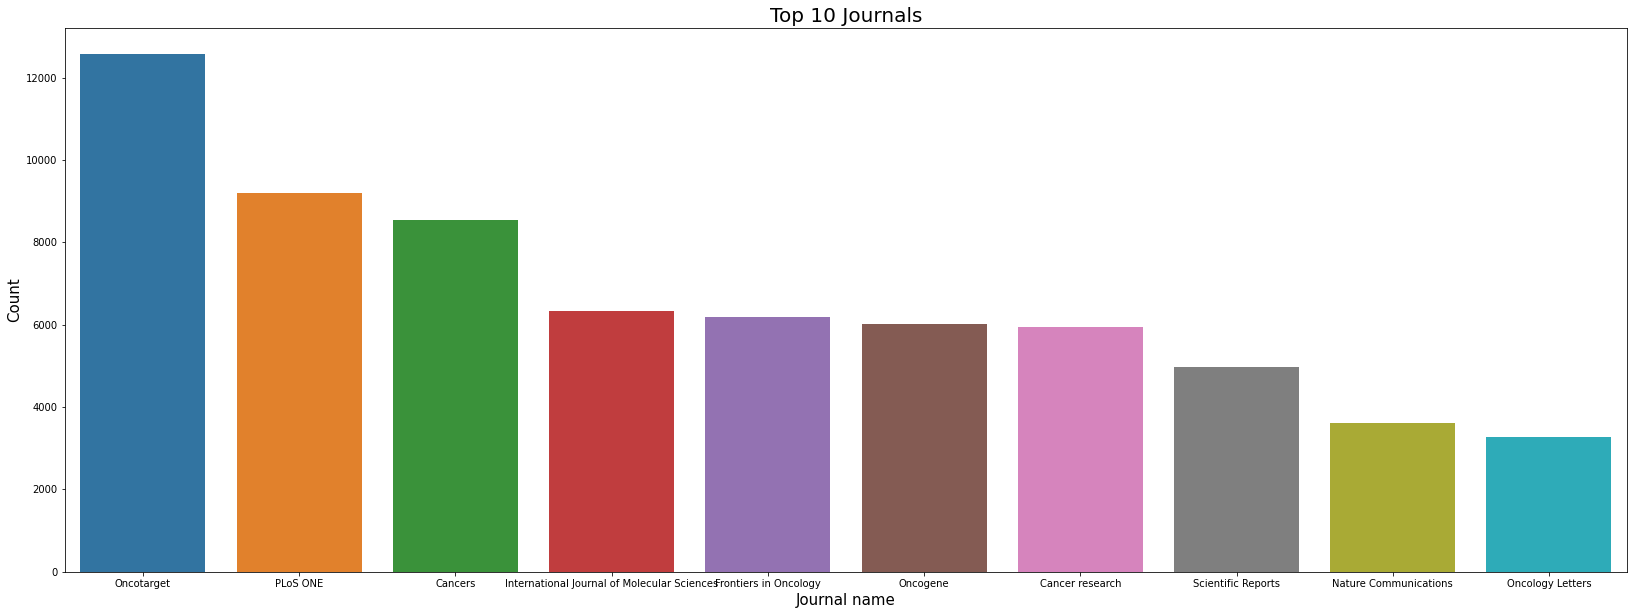

In [ ]:
plt.figure(figsize=(28,10))

name = journal2.index
vals = journal2.values

print(name, vals)

sns.barplot(x = name, y = vals)
plt.title('Top 10 Journals',fontsize = 20)
plt.xlabel('Journal name', fontsize = 15)
plt.ylabel('Count',fontsize = 15)
plt.show()

'Oncotarget', 'PLoS ONE', 'Cancers' are the top 3 journals that are referred for this dataset. 

### Types of Genes

In [ ]:
gene = Master_dataset['gene_normalized'].value_counts()
gene

KRAS       11868
MYC        10585
TP53        9955
EGFR        6366
PTEN        4751
           ...  
CFAP251        1
ATP5F1A        1
HM13           1
STIP1          1
HSPA14         1
Name: gene_normalized, Length: 8415, dtype: int64

In [ ]:
#the top 10
gene2 = gene[:10].copy()

#others
new_row = pd.DataFrame(data = {
    'name' : ['others'],
    'value' : [gene.values[10:].sum()]
})

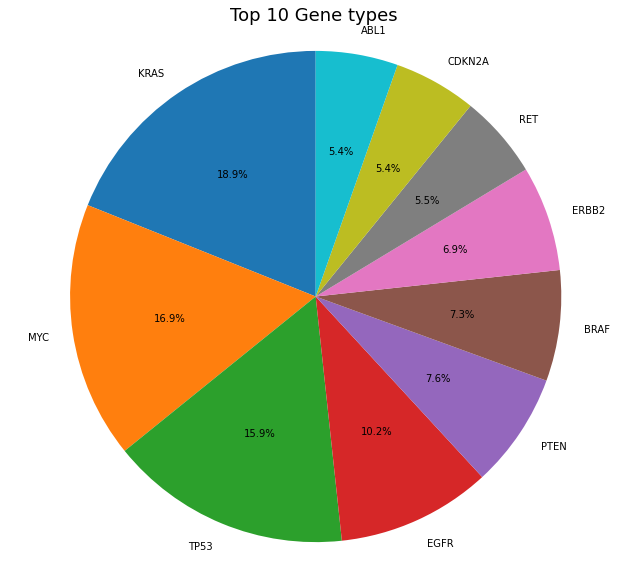

In [ ]:
name = gene2.index
vals = gene2.values
figp, axp = plt.subplots(figsize=(11,10))

axp.pie(vals , labels=name, autopct='%1.1f%%', startangle=90,)
axp.axis('equal')
plt.title('Top 10 Gene types', fontsize=18)
plt.show()

We can clearly see that KRAS, MYC, TP53 are the top 3 citied genes

### Types of Cancer

In [ ]:
### Calculating Unique Types of  Cancers ######
cancer_types = np.unique(Master_dataset['cancer_normalized'])
print("Unique types of cancer: ",len(cancer_types)) # we have 621 cancer types (too much to visualize)

Unique types of cancer:  621


In [ ]:
# making a list of the cancers that we care about for this specific project
cancers_of_interest = [] 
for cancer in cancer_types: 
  if re.search('lung', cancer): 
    cancers_of_interest.append(cancer)
  elif re.search('colon', cancer):
    cancers_of_interest.append(cancer)
  elif re.search('pancrea', cancer):
    cancers_of_interest.append(cancer)
  else: continue
print("Number of Cancer types: ",len(cancers_of_interest)) # only 31 types of cancers found
print("Cancer List:\n",cancers_of_interest)

Number of Cancer types:  31
Cancer List:
 ['asbestos-related lung carcinoma', 'colon adenocarcinoma', 'colon cancer', 'colon carcinoma', 'colon mucinous adenocarcinoma', 'colon sarcoma', 'lung adenocarcinoma', 'lung adenoid cystic carcinoma', 'lung cancer', 'lung carcinoma', 'lung combined type small cell carcinoma', 'lung giant cell carcinoma', 'lung large cell carcinoma', 'lung non-small cell carcinoma', 'lung oat cell carcinoma', 'lung papillary adenocarcinoma', 'lung sarcoma', 'lung sarcomatoid carcinoma', 'lung small cell carcinoma', 'lung squamous cell carcinoma', 'malignant exocrine pancreas neoplasm', 'mucinous lung adenocarcinoma', 'non-functioning pancreatic endocrine tumor', 'pancreatic acinar cell adenocarcinoma', 'pancreatic adenocarcinoma', 'pancreatic adenosquamous carcinoma', 'pancreatic cancer', 'pancreatic carcinoma', 'pancreatic ductal adenocarcinoma', 'pancreatic ductal carcinoma', 'pancreatic endocrine carcinoma']


In [ ]:
filtered_dataset = Master_dataset[Master_dataset['cancer_normalized'].isin(cancers_of_interest)]
print("Shape of Filtered Data: ", filtered_dataset.shape)

Shape of Filtered Data:  (52473, 24)


Text(0, 0.5, 'Count')

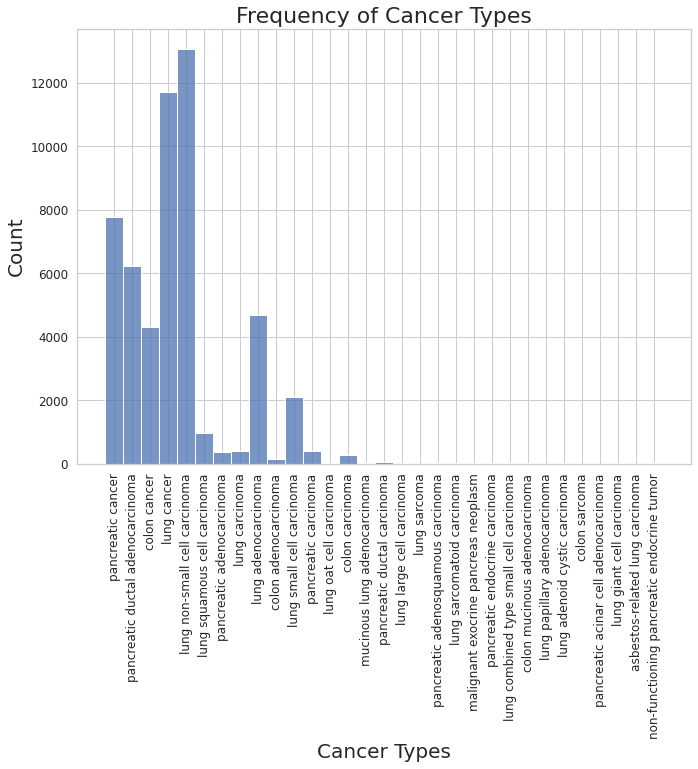

In [ ]:
## Plotting Data Distribution of Cancer types ##
sns.set(rc = {'figure.figsize':(11,8)})
sns.set_style('whitegrid')
ax = sns.histplot(filtered_dataset, x='cancer_normalized')
ax.tick_params(axis='x', labelrotation = 90)
ax.tick_params(labelsize=12)
ax.axes.set_title("Frequency of Cancer Types",fontsize=22)
ax.set_xlabel("Cancer Types", fontsize=20)
ax.set_ylabel("Count", fontsize=20)

Here we are looking at the frequency of the 31 different cancer types that matched my search query. Of the 31 cancer types we see that we have a larger proportion of cancers that are for the lungs. This is showing that our data is skewed towards lung cancers, so to deal with this we will have to choose a random subsample from our filtered data frame. 

### Relationship between Gene, Cancer

In [ ]:
rel = filtered_dataset.groupby(['gene_normalized', 'cancer_normalized'])['journal'].count().sort_values(ascending=False)
rel

gene_normalized  cancer_normalized               
KRAS             pancreatic ductal adenocarcinoma    2351
EGFR             lung non-small cell carcinoma       2044
KRAS             pancreatic cancer                   2017
                 lung cancer                         1613
                 lung non-small cell carcinoma       1547
                                                     ... 
KDM4A            lung carcinoma                         1
                 lung adenocarcinoma                    1
                 colon cancer                           1
KDM3A            pancreatic ductal adenocarcinoma       1
ZYX              pancreatic cancer                      1
Name: journal, Length: 9140, dtype: int64

In [ ]:
#the top 10
rel2 = rel[:10].copy()
rel2

gene_normalized  cancer_normalized               
KRAS             pancreatic ductal adenocarcinoma    2351
EGFR             lung non-small cell carcinoma       2044
KRAS             pancreatic cancer                   2017
                 lung cancer                         1613
                 lung non-small cell carcinoma       1547
EGFR             lung cancer                          997
ALK              lung non-small cell carcinoma        914
KRAS             lung adenocarcinoma                  840
EGFR             lung adenocarcinoma                  611
CD274            lung non-small cell carcinoma        563
Name: journal, dtype: int64

KRAS, EGFR, TP53 are the most common genes in the filtered cancer types. 

In [ ]:
prediction = filtered_dataset['predictprob'].sort_values()
prediction

180440    0.500003
193196    0.500007
137464    0.500021
69950     0.500044
188902    0.500044
            ...   
185471    0.999824
8232      0.999829
161454    0.999851
8231      0.999922
124013    0.999988
Name: predictprob, Length: 52473, dtype: float64

**Outlier**

The outliers will be removed based on the predictive probability column

Text(0, 0.5, 'Count')

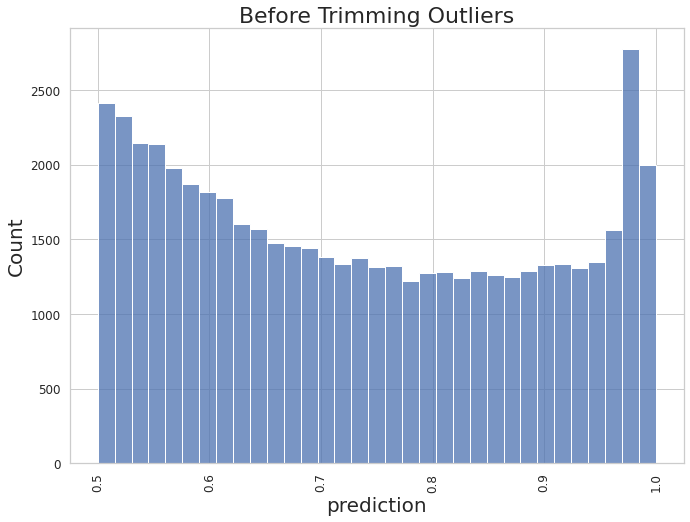

In [ ]:
## Plotting Predicted Probability distributions ##

ax = sns.histplot(filtered_dataset, x='predictprob')
ax.tick_params(axis='x', labelrotation = 90)
ax.tick_params(labelsize=12)
ax.axes.set_title("Before Trimming Outliers",fontsize=22)
ax.set_xlabel("prediction", fontsize=20)
ax.set_ylabel("Count", fontsize=20)

It seems that we have outliers at both ends of the spectrum. To mitigate this issue I will use std deviation method to find and get rid of the outliers. 

In [ ]:
upper_limit = (filtered_dataset['predictprob'].mean()+
               (1*filtered_dataset['predictprob'].std())
               )
lower_limit = (filtered_dataset['predictprob'].mean()-
               (1*filtered_dataset['predictprob'].std())
               )
print(upper_limit, lower_limit)

0.8912316488137892 0.5798272985536705


In [ ]:
new_filtered_data = filtered_dataset.loc[(filtered_dataset['predictprob']<upper_limit) 
& (filtered_dataset['predictprob']>lower_limit)]
print("old filtered data: ", filtered_dataset.shape)
print('new filtered data: ', new_filtered_data.shape)

old filtered data:  (52473, 24)
new filtered data:  (29071, 24)


Text(0, 0.5, 'Count')

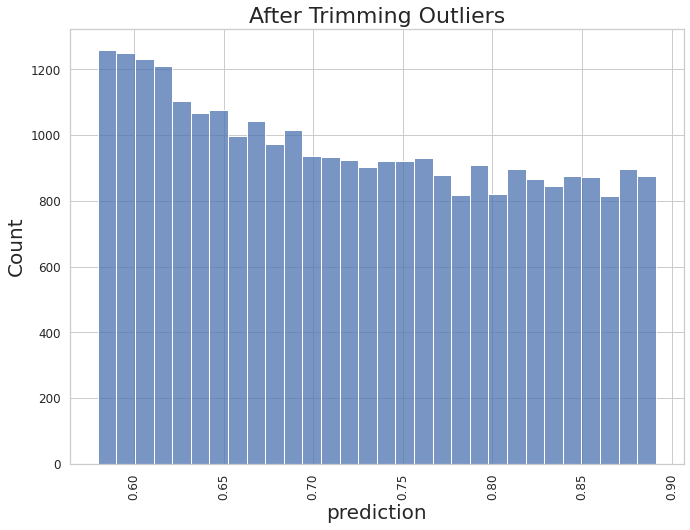

In [ ]:
ax = sns.histplot(new_filtered_data, x='predictprob')
ax.tick_params(axis='x', labelrotation = 90)
ax.tick_params(labelsize=12)
ax.axes.set_title("After Trimming Outliers",fontsize=22)
ax.set_xlabel("prediction", fontsize=20)
ax.set_ylabel("Count", fontsize=20)

**Text Cleaning and Featurization**

In [ ]:
# --- Removing any special characters ---
new_filtered_data['sentence'] = [ row for row in new_filtered_data['sentence']]
new_filtered_data['sentence']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


27        These findings extended to cancer cell lines a...
28        These findings extended to cancer cell lines a...
33        Mutant KRAS is the most prominent oncogene in ...
34        This effect was also dramatically seen in two ...
35        This effect was also dramatically seen in two ...
                                ...                        
251722    Lung resections obtained from 52 Chinese patie...
251723    Lung resections obtained from 52 Chinese patie...
251729    Specific inhibition of K-ras oncogene expressi...
251745    The clinical importance of ras oncogene produc...
251799    Activation of the Ki-ras oncogene by specific ...
Name: sentence, Length: 29071, dtype: object

In [ ]:
# --- Text Normalization (changing all characters to lowercase) ---
lower_array = []
for sentence in new_filtered_data['sentence']:
  # changing everything to lower case and removing all special characters
  text_clean = "".join([i.lower() and re.sub('[^-9A-Za-z ]', '', i) for i in sentence])
  lower_array.append(text_clean)
new_filtered_data['sentence'] = lower_array
new_filtered_data['sentence'] # now our text column is clean and normalized 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


27        These findings extended to cancer cell lines a...
28        These findings extended to cancer cell lines a...
33        Mutant KRAS is the most prominent oncogene in ...
34        This effect was also dramatically seen in two ...
35        This effect was also dramatically seen in two ...
                                ...                        
251722    Lung resections obtained from  Chinese patient...
251723    Lung resections obtained from  Chinese patient...
251729    Specific inhibition of K-ras oncogene expressi...
251745    The clinical importance of ras oncogene produc...
251799    Activation of the Ki-ras oncogene by specific ...
Name: sentence, Length: 29071, dtype: object

**Removing Stopwords and Tokenization**

In [ ]:
nltk.download('stopwords') # stopwords
nltk.download('punkt') # tokenizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
stopwords = nltk.corpus.stopwords.words('english')
# tokenizing each sentence 
test = [nltk.tokenize.word_tokenize(sentence) for 
        sentence in new_filtered_data['sentence']
        ]

# Removing stop words and putting sentences back together
arr=[]
for list_ofWords in test:
    words = " ".join([i for i in list_ofWords if i not in stopwords])
    arr.append(words)
new_filtered_data['sentence'] = arr # cleaned up sentences without any stopwords
# might have to tokenize twice to create vectors for downstream analysis

['These findings extended cancer cell lines patient-derived xenograft models highly refractory pancreatic cancer osteosarcoma driven KRAS MYC oncogenes',
 'These findings extended cancer cell lines patient-derived xenograft models highly refractory pancreatic cancer osteosarcoma driven KRAS MYC oncogenes',
 'Mutant KRAS prominent oncogene human cancers particular pancreatic cancer carries highest rate mutation KRAS one lethal type tumor',
 'This effect also dramatically seen two PDX models metastatic OS high MYC copy number well two pancreatic ductal adenocarcinoma PDAC cell lines driven KRAS mutation MYC amplification',
 'This effect also dramatically seen two PDX models metastatic OS high MYC copy number well two pancreatic ductal adenocarcinoma PDAC cell lines driven KRAS mutation MYC amplification',
 'This included HLA-A protein found commonly dysregulated across six isogenic models proliferative oncogenes PDAC cell lines',
 'Adenomatous polyposis coli APC tumor suppressor gene who